In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [91]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import cv2

In [92]:
np.random.seed(0)

In [93]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
  
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
  
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)
  
print(type(train_data))

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']


<class 'dict'>


In [94]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [95]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0])    , "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0])  , "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3))     , "The dimensions of images are not 32x32x3"
assert(X_val.shape[1:] == (32, 32, 3))       , "The dimensions of images are not 32x32x3"
assert(X_test.shape[1:] == (32, 32, 3))      , "The dimensions of images are not 32x32x3"

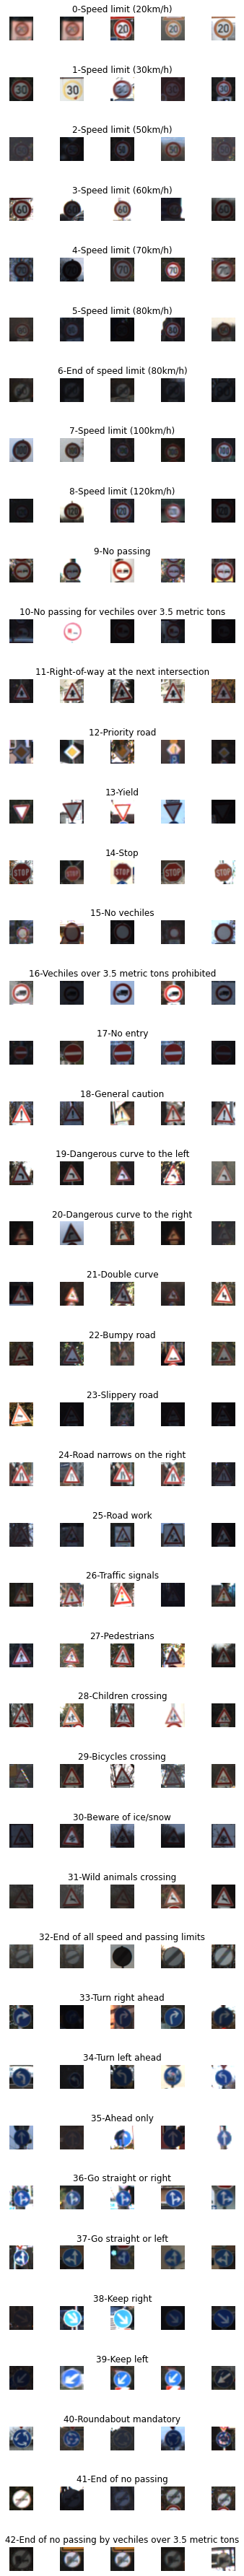

In [96]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + "-" + row["SignName"])
        num_of_samples.append(len(x_selected))


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


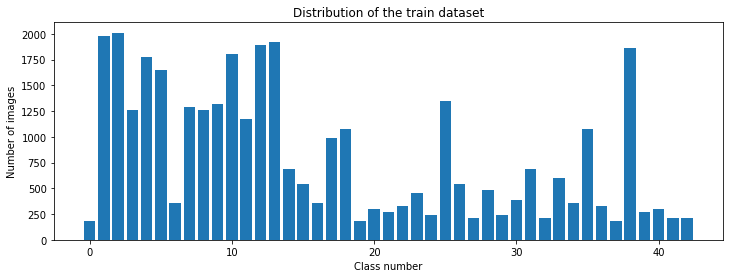

In [97]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()


(32, 32, 3)
36


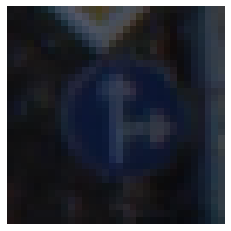

In [98]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


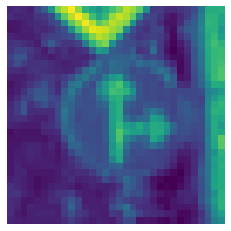

In [99]:
def grayscale(inpImg):
  inpImg = cv2.cvtColor(inpImg, cv2.COLOR_BGR2GRAY)
  return inpImg

gray = grayscale(X_train[1000])

plt.imshow(gray)
plt.axis("off")
print(gray.shape)

(32, 32)


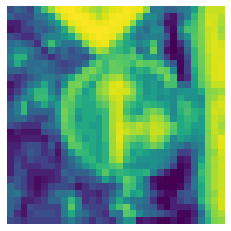

In [100]:
def equalize(inpImage):
  inpImage = cv2.equalizeHist(inpImage)
  return inpImage

equ = equalize(gray)
plt.imshow(equ)
plt.axis("off")
print(gray.shape)
  


In [101]:
def preprocess(img):
  img = grayscale(img)
  img = equalize(img)
  img = img / 255
  
  return img

X_train = np.array(list(map(preprocess, X_train)))
X_val   = np.array(list(map(preprocess, X_val)))
X_test  = np.array(list(map(preprocess, X_test)))

(34799, 32, 32)


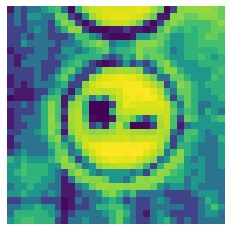

In [102]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [103]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [104]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                   height_shift_range = 0.1,
                   zoom_range = 0.2,
                   shear_range = 0.1,
                   rotation_range = 10)

datagen.fit(X_train)

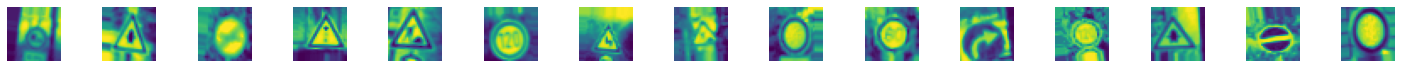

In [105]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [106]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [107]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [108]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
  model.add(Conv2D(60, (5, 5), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation = 'relu'))
  model.add(Conv2D(30, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))
  
  #Compile model
  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  
  return model

In [109]:
model = leNet_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 30)         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [110]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 50), steps_per_epoch = 2000, epochs = 10, validation_data = (X_val, y_val), shuffle = 1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
2000/2000 [==============================] - 22s 11ms/step - loss: 2.2143 - accuracy: 0.3741 - val_loss: 0.5949 - val_accuracy: 0.8372


Text(0.5, 0, 'epoch')

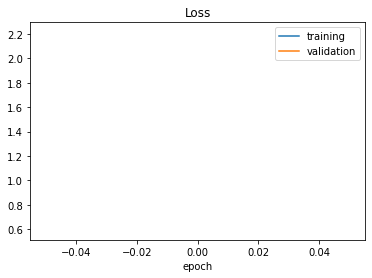

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

In [112]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test score: ', score[0])
print('Test Accuracy: ', score[1])

Test score:  0.6561897397041321
Test Accuracy:  0.8122723698616028


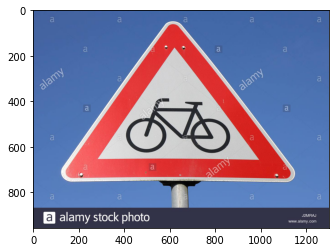

In [113]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


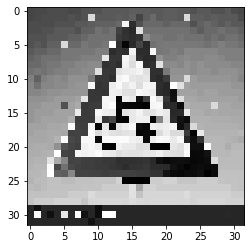

In [114]:
#Preprocess image 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [115]:
img = img.reshape(1, 32, 32, 1)

In [116]:
#Test image
print("predicted sign: "+ str(model.predict(img)))

predicted sign: [[9.1089203e-07 4.6890787e-06 3.4621751e-06 4.7520834e-07 8.2092197e-07
  2.4934209e-06 8.5830088e-08 7.3156180e-08 1.7248658e-08 8.0786418e-09
  3.5724696e-07 2.7018082e-03 1.5210489e-05 1.5379206e-09 7.2699424e-07
  3.4075985e-08 1.6386362e-08 8.8741800e-08 4.3798286e-02 7.2054849e-03
  3.1869514e-03 7.6533426e-03 1.0453583e-01 5.6220964e-03 1.1663506e-01
  4.6984994e-01 2.9362304e-02 1.6823286e-02 2.8821880e-02 4.5633141e-02
  2.5856361e-02 9.2191070e-02 1.5053809e-09 8.5168847e-07 8.9347913e-07
  2.8611271e-06 4.8211120e-07 7.1788338e-05 4.4474714e-06 3.5033001e-06
  8.7693788e-06 2.4060280e-09 6.9130110e-08]]


In [118]:
y_prob = model.predict(img) 
y_classes = y_prob.argmax(axis=-1)

In [119]:
labels = []
labels_col = data.SignName
for i in labels_col:
    labels.append(i)

In [121]:
predicted_label = sorted(labels)[y_classes[0]]